# Galacticus Subhalo Population Emulation Using Normalizing Flows

Goal is to emulate the PDF of the Galacticus-predicted subhalo population using normalizing flows. This will allow for rapid generation of realizations of subhalo populations (as normalizing flows are invertible and can thereby be used as generative models). By emulating all properties required to fully define each subhalo, the resulting emulator could be used to generate a realization which is then processed through Galacticus to construct detailed density profiles etc.

The approach is closely based on that describe [here](https://keras.io/examples/generative/real_nvp/).

Some caveats:
1. This approach will not reproduce any correlations between subhalos (which may arise due to mass conservation constraints for example);
2. We currently ignore the subhalo hierarchy (i.e. all subhalos are subhalos, there are no sub-subhalos);

In [1]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import regularizers
from sklearn.preprocessing import MinMaxScaler
import numpy as np
import matplotlib.pyplot as plt
import tensorflow_probability as tfp
import h5py
import os

2022-04-27 11:11:34.445363: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /central/software/python/3.7.0/lib:/home/abenson/Tools/lib:/home/abenson/Tools/lib64:/central/slurm/install/current/lib/:
2022-04-27 11:11:34.445440: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


Run a standard Galacticus model to generate subhalos for a number of trees with $z=0$ halo mass of $10^{12}\mathrm{M}_\odot$. This model resolves down to $10^6\mathrm{M}_\odot$ but uses subsampling of tree branches to avoid huge compute times. We will need to take the subsampling weights into account when training the normalizing flow.

In [2]:
os.system("cd ../../..; ./Galacticus.exe projects/normalizingFlows/parameters/darkMatterOnlySubHalos.xml")

              ##                                     
   ####        #                  #                  
  #   #        #             #                       
 #       ###   #  ###   ### ###  ##   ### ## ##   ## 
 #       #  #  #  #  # #  #  #    #  #  #  #  #  #   
 #   ###  ###  #   ### #     #    #  #     #  #   #  
  #   #  #  #  #  #  # #     #    #  #     #  #    # 
   ####  #### ### ####  ###   ## ###  ###   #### ##  

 © 2009, 2010, 2011, 2012, 2013, 2014, 2015, 2016,
   2017, 2018, 2019, 2020, 2021, 2022
   - Andrew Benson

MM: Memory:         code +      nodes +       misc =      total
MM:            30.383Mib +   1.000  b +   9.000  b =   8.555Mib
MM: Memory:         code +      nodes +       misc =      total
MM:            30.383Mib +   1.000  b +  26.376kib =  10.902Mib
MM: Memory:         code +      nodes +       misc =      total
MM:            30.383Mib +   1.000  b +  71.724kib =  13.387Mib
MM: Memory:         code +      nodes +       misc =      total
MM:       

 4:     <- Finished tree
25:     -> Evolving tree number 967 {1}
27:     -> Evolving tree number 965 {1}
12:         Output tree data at t=  13.80 Gyr
19:     -> Evolving tree number 973 {1}
24:     <- Finished tree
13:     -> Evolving tree number 979 {1}
 1:     <- Finished tree
31:     -> Evolving tree number 961 {1}
 6:     -> Evolving tree number 986 {1}
 6:         Memory:         code +       misc +    unknown =      total
 6:                    30.383Mib + 277.083Mib +   3.678Gib =   3.978Gib
14:     -> Evolving tree number 978 {1}
12:     <- Finished tree
22:     -> Evolving tree number 970 {1}
29:         Output tree data at t=  13.80 Gyr
 5:     -> Evolving tree number 987 {1}
15:     -> Evolving tree number 977 {1}
 3:     -> Evolving tree number 989 {1}
18:     -> Evolving tree number 974 {1}
 8:     -> Evolving tree number 984 {1}
21:         Output tree data at t=  13.80 Gyr
17:         Output tree data at t=  13.80 Gyr
20:         Output tree data at t=  13.80 Gyr
11:   

25:     <- Finished tree
19:     <- Finished tree
13:     <- Finished tree
26:     <- Finished tree
23:     <- Finished tree
14:     -> Evolving tree number 914 {1}
 6:     <- Finished tree
22:     <- Finished tree
 2:     <- Finished tree
28:         Output tree data at t=  13.80 Gyr
 7:     -> Evolving tree number 921 {1}
31:         Output tree data at t=  13.80 Gyr
 3:     -> Evolving tree number 925 {1}
 8:         Output tree data at t=  13.80 Gyr
16:     -> Evolving tree number 880 {1}
 5:     -> Evolving tree number 923 {1}
11:     -> Evolving tree number 917 {1}
15:     -> Evolving tree number 913 {1}
28:     <- Finished tree
 1:     -> Evolving tree number 895 {1}
31:     <- Finished tree
 4:         Output tree data at t=  13.80 Gyr
20:         Output tree data at t=  13.80 Gyr
 8:     <- Finished tree
12:     -> Evolving tree number 884 {1}
14:         Output tree data at t=  13.80 Gyr
 4:     <- Finished tree
16:         Output tree data at t=  13.80 Gyr
20:     <- Finishe

 9:     -> Evolving tree number 823 {1}
 6:     -> Evolving tree number 826 {1}
27:         Output tree data at t=  13.80 Gyr
29:         Output tree data at t=  13.80 Gyr
11:     <- Finished tree
14:         Output tree data at t=  13.80 Gyr
23:     -> Evolving tree number 809 {1}
21:     -> Evolving tree number 811 {1}
20:     <- Finished tree
 7:     -> Evolving tree number 857 {1}
29:     <- Finished tree
27:     <- Finished tree
10:         Output tree data at t=  13.80 Gyr
 2:     -> Evolving tree number 798 {1}
22:     -> Evolving tree number 810 {1}
 5:     -> Evolving tree number 859 {1}
15:         Output tree data at t=  13.80 Gyr
 3:     -> Evolving tree number 861 {1}
14:     <- Finished tree
17:         Output tree data at t=  13.80 Gyr
19:         Output tree data at t=  13.80 Gyr
18:     -> Evolving tree number 846 {1}
30:     -> Evolving tree number 802 {1}
25:         Output tree data at t=  13.80 Gyr
 6:         Output tree data at t=  13.80 Gyr
 0:     -> Evolving t

15:         Output tree data at t=  13.80 Gyr
22:     <- Finished tree
18:     -> Evolving tree number 782 {1}
21:     <- Finished tree
20:     <- Finished tree
 9:         Output tree data at t=  13.80 Gyr
 2:     <- Finished tree
13:     -> Evolving tree number 755 {1}
 3:     -> Evolving tree number 797 {1}
 7:     -> Evolving tree number 793 {1}
 1:         Output tree data at t=  13.80 Gyr
30:     -> Evolving tree number 738 {1}
15:     <- Finished tree
 5:     -> Evolving tree number 795 {1}
 8:         Output tree data at t=  13.80 Gyr
12:         Output tree data at t=  13.80 Gyr
16:     <- Finished tree
14:     <- Finished tree
24:     -> Evolving tree number 744 {1}
 9:     <- Finished tree
 1:     <- Finished tree
 4:         Output tree data at t=  13.80 Gyr
 8:     <- Finished tree
12:     <- Finished tree
28:     -> Evolving tree number 740 {1}
13:         Output tree data at t=  13.80 Gyr
29:     -> Evolving tree number 707 {1}
27:     -> Evolving tree number 709 {1}
 5:

28:     -> Evolving tree number 676 {1}
17:     -> Evolving tree number 655 {1}
29:         Output tree data at t=  13.80 Gyr
22:     -> Evolving tree number 650 {1}
 2:     -> Evolving tree number 638 {1}
 6:     -> Evolving tree number 666 {1}
21:     -> Evolving tree number 651 {1}
 5:     <- Finished tree
25:     -> Evolving tree number 647 {1}
19:     <- Finished tree
16:     -> Evolving tree number 624 {1}
 7:         Output tree data at t=  13.80 Gyr
 3:         Output tree data at t=  13.80 Gyr
23:         Output tree data at t=  13.80 Gyr
27:     <- Finished tree
13:     <- Finished tree
 8:     -> Evolving tree number 664 {1}
29:     <- Finished tree
 3:     <- Finished tree
10:         Output tree data at t=  13.80 Gyr
 7:     <- Finished tree
30:         Output tree data at t=  13.80 Gyr
 1:     -> Evolving tree number 639 {1}
18:         Output tree data at t=  13.80 Gyr
 2:         Output tree data at t=  13.80 Gyr
21:         Output tree data at t=  13.80 Gyr
23:     <- 

 1:     <- Finished tree
22:         Output tree data at t=  13.80 Gyr
17:     <- Finished tree
10:     <- Finished tree
 8:         Output tree data at t=  13.80 Gyr
 3:         Output tree data at t=  13.80 Gyr
11:     -> Evolving tree number 629 {1}
12:         Output tree data at t=  13.80 Gyr
30:         Output tree data at t=  13.80 Gyr
22:     <- Finished tree
 4:         Output tree data at t=  13.80 Gyr
 7:         Output tree data at t=  13.80 Gyr
 8:     <- Finished tree
31:     -> Evolving tree number 609 {1}
28:         Output tree data at t=  13.80 Gyr
18:         Output tree data at t=  13.80 Gyr
19:     -> Evolving tree number 557 {1}
 3:     <- Finished tree
12:     <- Finished tree
24:         Output tree data at t=  13.80 Gyr
30:     <- Finished tree
27:     -> Evolving tree number 549 {1}
14:     -> Evolving tree number 626 {1}
 4:     <- Finished tree
26:     -> Evolving tree number 614 {1}
28:     <- Finished tree
 7:     <- Finished tree
29:     -> Evolving tree 

22:     -> Evolving tree number 490 {1}
 2:     -> Evolving tree number 478 {1}
24:         Output tree data at t=  13.80 Gyr
29:         Output tree data at t=  13.80 Gyr
18:     <- Finished tree
10:     -> Evolving tree number 502 {1}
28:     <- Finished tree
11:         Output tree data at t=  13.80 Gyr
25:         Output tree data at t=  13.80 Gyr
 8:     -> Evolving tree number 504 {1}
26:     -> Evolving tree number 550 {1}
21:         Output tree data at t=  13.80 Gyr
23:     <- Finished tree
31:         Output tree data at t=  13.80 Gyr
 1:     -> Evolving tree number 479 {1}
16:         Output tree data at t=  13.80 Gyr
17:         Output tree data at t=  13.80 Gyr
24:     <- Finished tree
15:     -> Evolving tree number 561 {1}
11:     <- Finished tree
29:     <- Finished tree
20:     -> Evolving tree number 556 {1}
 0:         Output tree data at t=  13.80 Gyr
 2:         Output tree data at t=  13.80 Gyr
12:     -> Evolving tree number 468 {1}
22:         Output tree data a

11:     <- Finished tree
 1:     <- Finished tree
27:     -> Evolving tree number 389 {1}
24:     <- Finished tree
20:     -> Evolving tree number 492 {1}
 4:     <- Finished tree
 6:     <- Finished tree
14:         Output tree data at t=  13.80 Gyr
 5:     -> Evolving tree number 507 {1}
31:         Output tree data at t=  13.80 Gyr
12:     <- Finished tree
 0:     -> Evolving tree number 832 {1}
 9:     -> Evolving tree number 471 {1}
26:         Output tree data at t=  13.80 Gyr
14:     <- Finished tree
13:     -> Evolving tree number 467 {1}
15:         Output tree data at t=  13.80 Gyr
31:     <- Finished tree
26:     <- Finished tree
19:         Output tree data at t=  13.80 Gyr
29:     -> Evolving tree number 387 {1}
27:         Output tree data at t=  13.80 Gyr
20:         Output tree data at t=  13.80 Gyr
15:     <- Finished tree
17:     -> Evolving tree number 399 {1}
19:     <- Finished tree
 5:         Output tree data at t=  13.80 Gyr
23:     -> Evolving tree number 393 {

20:         Output tree data at t=  13.80 Gyr
22:     -> Evolving tree number 330 {1}
10:     -> Evolving tree number 342 {1}
12:     -> Evolving tree number 308 {1}
26:     <- Finished tree
 8:         Output tree data at t=  13.80 Gyr
 2:         Output tree data at t=  13.80 Gyr
17:     <- Finished tree
15:         Output tree data at t=  13.80 Gyr
21:         Output tree data at t=  13.80 Gyr
20:     <- Finished tree
 4:     -> Evolving tree number 316 {1}
 6:     -> Evolving tree number 346 {1}
30:     -> Evolving tree number 386 {1}
 8:     <- Finished tree
16:         Output tree data at t=  13.80 Gyr
 5:         Output tree data at t=  13.80 Gyr
 2:     <- Finished tree
 9:         Output tree data at t=  13.80 Gyr
25:         Output tree data at t=  13.80 Gyr
 1:         Output tree data at t=  13.80 Gyr
15:     <- Finished tree
21:     <- Finished tree
 7:     -> Evolving tree number 441 {1}
10:         Output tree data at t=  13.80 Gyr
22:         Output tree data at t=  13.

22:     <- Finished tree
27:         Output tree data at t=  13.80 Gyr
25:     <- Finished tree
 7:     -> Evolving tree number 377 {1}
19:         Output tree data at t=  13.80 Gyr
15:         Output tree data at t=  13.80 Gyr
 9:     <- Finished tree
23:     -> Evolving tree number 233 {1}
 5:         Output tree data at t=  13.80 Gyr
27:     <- Finished tree
19:     <- Finished tree
15:     <- Finished tree
30:         Output tree data at t=  13.80 Gyr
17:     -> Evolving tree number 239 {1}
29:         Output tree data at t=  13.80 Gyr
28:     -> Evolving tree number 324 {1}
 5:     <- Finished tree
 7:         Output tree data at t=  13.80 Gyr
30:     <- Finished tree
29:     <- Finished tree
21:     -> Evolving tree number 235 {1}
 3:     -> Evolving tree number 381 {1}
23:         Output tree data at t=  13.80 Gyr
11:     -> Evolving tree number 341 {1}
 8:     -> Evolving tree number 248 {1}
 2:     -> Evolving tree number 222 {1}
28:         Output tree data at t=  13.80 Gyr
1

22:     -> Evolving tree number 170 {1}
25:     -> Evolving tree number 167 {1}
 5:     <- Finished tree
16:         Output tree data at t=  13.80 Gyr
12:     -> Evolving tree number 148 {1}
 3:     -> Evolving tree number 317 {1}
 1:     <- Finished tree
28:         Output tree data at t=  13.80 Gyr
 0:     <- Finished tree
 8:     <- Finished tree
 2:     <- Finished tree
 7:     <- Finished tree
21:     <- Finished tree
27:     -> Evolving tree number 133 {1}
26:     -> Evolving tree number 262 {1}
11:     -> Evolving tree number 277 {1}
18:     -> Evolving tree number 302 {1}
19:     -> Evolving tree number 141 {1}
22:         Output tree data at t=  13.80 Gyr
 6:         Output tree data at t=  13.80 Gyr
28:     <- Finished tree
16:     <- Finished tree
29:     -> Evolving tree number 131 {1}
25:         Output tree data at t=  13.80 Gyr
14:     -> Evolving tree number 274 {1}
 4:     -> Evolving tree number 156 {1}
22:     <- Finished tree
12:         Output tree data at t=  13.8

 4:     <- Finished tree
18:         Output tree data at t=  13.80 Gyr
14:     -> Evolving tree number 210 {1}
17:         Output tree data at t=  13.80 Gyr
 2:     -> Evolving tree number 62 {1}
21:     -> Evolving tree number 75 {1}
23:         Output tree data at t=  13.80 Gyr
13:     -> Evolving tree number 179 {1}
10:         Output tree data at t=  13.80 Gyr
 1:     -> Evolving tree number 63 {1}
26:         Output tree data at t=  13.80 Gyr
31:     -> Evolving tree number 193 {1}
18:     <- Finished tree
17:     <- Finished tree
24:     -> Evolving tree number 200 {1}
11:         Output tree data at t=  13.80 Gyr
16:     -> Evolving tree number 48 {1}
10:     <- Finished tree
23:     <- Finished tree
15:     -> Evolving tree number 209 {1}
 3:         Output tree data at t=  13.80 Gyr
26:     <- Finished tree
 8:     -> Evolving tree number 88 {1}
 9:     -> Evolving tree number 183 {1}
13:         Output tree data at t=  13.80 Gyr
14:         Output tree data at t=  13.80 Gyr
1

 5:     -> Evolving tree number 155 {1}
25:     -> Evolving tree number 7 {1}
 9:     <- Finished tree
 6:         Output tree data at t=  13.80 Gyr
 8:     <- Finished tree
 0:     -> Evolving tree number 704 {1}
28:     -> Evolving tree number 100 {1}
13:     <- Finished tree
30:     -> Evolving tree number 98 {1}
31:     <- Finished tree
20:         Output tree data at t=  13.80 Gyr
22:         Output tree data at t=  13.80 Gyr
15:         Output tree data at t=  13.80 Gyr
 7:         Output tree data at t=  13.80 Gyr
18:     -> Evolving tree number 142 {1}
 6:     <- Finished tree
20:     <- Finished tree
15:     <- Finished tree
10:     -> Evolving tree number 22 {1}
 7:     <- Finished tree
22:     <- Finished tree
28:         Output tree data at t=  13.80 Gyr
 5:         Output tree data at t=  13.80 Gyr
 3:     -> Evolving tree number 157 {1}
25:         Output tree data at t=  13.80 Gyr
30:         Output tree data at t=  13.80 Gyr
11:     -> Evolving tree number 117 {1}
18:  

 0:         Output tree data at t=  13.80 Gyr
 0:     <- Finished tree
 0:     -> Evolving tree number 448 {1}
 0:         Output tree data at t=  13.80 Gyr
 0:     <- Finished tree
 0:     -> Evolving tree number 416 {1}
 0:         Output tree data at t=  13.80 Gyr
 0:     <- Finished tree
 0:     -> Evolving tree number 384 {1}
 0:         Output tree data at t=  13.80 Gyr
 0:     <- Finished tree
 0:     -> Evolving tree number 352 {1}
 0:         Output tree data at t=  13.80 Gyr
 0:     <- Finished tree
 0:     -> Evolving tree number 320 {1}
 0:         Output tree data at t=  13.80 Gyr
 0:     <- Finished tree
 0:     -> Evolving tree number 288 {1}
 0:         Output tree data at t=  13.80 Gyr
 0:     <- Finished tree
 0:     -> Evolving tree number 256 {1}
 0:         Output tree data at t=  13.80 Gyr
 0:     <- Finished tree
 0:     -> Evolving tree number 224 {1}
 0:         Output tree data at t=  13.80 Gyr
 0:     <- Finished tree
 0:     -> Evolving tree number 192 {1}
 

0

Load all Galacticus data. Each subhalo is fully specified (more or less.....) by six parameters:
1. Infall mass, $M_\mathrm{inf}$;
2. Infall epoch, $z_\mathrm{inf}$;
3. Bound mass, $M_\mathrm{bound}$;
4. Concentration, $c$;
5. Orbital radius, $R_\mathrm{orbit}$;
6. Normalized specific tidal heating, $Q$.

(This assumes that the distribution is isotropic, so that only the orbital radius need be specified.)

We construct "normalized" versions of these properties that are better suited to modeling with a normalized flow:
1. $\log_{10}(M_\mathrm{inf}/M_\mathrm{vir, host})$;
2. $z_\mathrm{inf}$;
3. $\log_{10}(M_\mathrm{bound}/M_\mathrm{vir})$;
4. $c$;
5. $\log_{10}(R_\mathrm{orbit}/R_\mathrm{vir, host})$;
6. $\log_{10}(Q R_\mathrm{vir}^2/V_\mathrm{vir}^2+10^{-6})$.

We then use a `MaxMinScaler` object to shift these into a hypercube with verticies at $\pm1$.

As we typically run a subsampled Galacticus model (so we do not follow every subhalo, and, therefore, those that we do follow are assigned weights $> 1$ to account for this) we augment the scaled data with an extra column that contains the weights needed during training of the model.

In [2]:
f = h5py.File('../data/darkMatterOnlySubHalos.hdf5', 'r')
mergerTreeBuildMassesGroup = f['Parameters/mergerTreeBuildMasses']
massResolutionGroup = f['Parameters/mergerTreeMassResolution']
massTree = mergerTreeBuildMassesGroup.attrs['massTree'][0]
countTree = mergerTreeBuildMassesGroup.attrs['treeCount'][0]
massResolution = massResolutionGroup.attrs['massResolution']
weight = f['Outputs/Output1/nodeData/nodeSubsamplingWeight']
treeIndex = f['Outputs/Output1/nodeData/mergerTreeIndex']
isCentral = f['Outputs/Output1/nodeData/nodeIsIsolated']
massInfall = f['Outputs/Output1/nodeData/basicMass']
massBound = f['Outputs/Output1/nodeData/satelliteBoundMass']
concentration = f['Outputs/Output1/nodeData/concentration']
redshiftLastIsolated = f['Outputs/Output1/nodeData/redshiftLastIsolated']
positionOrbitalX = f['Outputs/Output1/nodeData/positionOrbitalX']
positionOrbitalY = f['Outputs/Output1/nodeData/positionOrbitalY']
positionOrbitalZ = f['Outputs/Output1/nodeData/positionOrbitalZ']
satelliteTidalHeating = f['Outputs/Output1/nodeData/satelliteTidalHeatingNormalized']
radiusVirial = f['Outputs/Output1/nodeData/darkMatterOnlyRadiusVirial']
velocityVirial = f['Outputs/Output1/nodeData/darkMatterOnlyVelocityVirial']
subhalos = (isCentral[:] == 0) & (massInfall[:] > 2.0*massResolution)
centrals = (isCentral[:] == 1)
countSubhalos = np.zeros(countTree)
for i in range(countTree):
    selectTree = (isCentral[:] == 0) & (treeIndex[:] == i+1)
    countSubhalos[i] = np.sum(weight[selectTree])
countSubhalosMean = np.mean(countSubhalos)
massHost = massInfall[centrals][0]
radiusVirialHost = radiusVirial[centrals][0]
velocityVirialHost = velocityVirial[centrals][0]
massInfallNormalized = np.log10(massInfall[subhalos]/massHost)
massBoundNormalized = np.log10(massBound[subhalos]/massInfall[subhalos])
concentrationNormalized = concentration[subhalos]
redshiftLastIsolatedNormalized = redshiftLastIsolated[subhalos]
radiusOrbitalNormalized = np.log10(np.sqrt(+positionOrbitalX[subhalos]**2+positionOrbitalY[subhalos]**2+positionOrbitalZ[subhalos]**2)/radiusVirialHost)
satelliteTidalHeatingNormalized = np.log10(1.0e-6+satelliteTidalHeating[subhalos]/velocityVirial[subhalos]**2*radiusVirial[subhalos]**2)
data=np.array(
    list(
        zip(
            massInfallNormalized,
            concentrationNormalized,
            massBoundNormalized,
            redshiftLastIsolatedNormalized,
            radiusOrbitalNormalized,
            satelliteTidalHeatingNormalized
        )
    )
)
scaler = MinMaxScaler(feature_range=(-1,1))
scaler.fit(data)
normalized_data = scaler.transform(data)
augmented_normalized_data = np.hstack((normalized_data, np.expand_dims(weight[subhalos],1)))
np.random.shuffle(augmented_normalized_data)
print("Number of subhalos: "+str(len(data)))
print("Mean number of subhalos per tree: "+str(countSubhalosMean))

Number of subhalos: 47412
Mean number of subhalos per tree: 9701.890558267323


Define the coupling layer (I haven't spent time understanding exactly what this does yet......)

In [3]:
# Creating a custom layer with keras API.
output_dim = 256
reg = 0.01


def Coupling(input_shape):
    input = keras.layers.Input(shape=input_shape)

    t_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    t_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_1)
    t_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_2)
    t_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_3)
    t_layer_5 = keras.layers.Dense(
        input_shape, activation="linear", kernel_regularizer=regularizers.l2(reg)
    )(t_layer_4)

    s_layer_1 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(input)
    s_layer_2 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_1)
    s_layer_3 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_2)
    s_layer_4 = keras.layers.Dense(
        output_dim, activation="relu", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_3)
    s_layer_5 = keras.layers.Dense(
        input_shape, activation="tanh", kernel_regularizer=regularizers.l2(reg)
    )(s_layer_4)

    return keras.Model(inputs=input, outputs=[s_layer_5, t_layer_5])

Create the "`RealNVP`" model. Some notes:

* The latent space PDF, `self.distribution`, is a standard multivariate normal distribution (note that using a distribution with finite support - e.g. a multivariate uniform - doesn't work well as the loss function is `-infinity` if any point lies outside of the supported region);
* The mask uses a checkerboard pattern (see Section 3.4 of this [paper](https://arxiv.org/pdf/1605.08803.pdf);
* The input shape passed to `Coupling()` when constructing `self.layers_list` must match the number of parameters describing each subhalo.

In [4]:
class RealNVP(keras.Model):
    def __init__(self, num_coupling_layers):
        super(RealNVP, self).__init__()

        self.num_coupling_layers = num_coupling_layers

        # Distribution of the latent space.
        self.distribution = tfp.distributions.MultivariateNormalDiag(
            loc=[0.0, 0.0, 0.0, 0.0, 0.0, 0.0], scale_diag=[1.0, 1.0, 1.0, 1.0, 1.0, 1.0]
        )
        self.masks = np.array(
            [[1, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1], [1, 0, 1, 0, 1, 0], [0, 1, 0, 1, 0, 1]] * (num_coupling_layers // 2), dtype="float32"
        )
        self.loss_tracker = keras.metrics.Mean(name="loss")
        self.layers_list = [Coupling(6) for i in range(num_coupling_layers)]

    @property
    def metrics(self):
        """List of the model's metrics.
        We make sure the loss tracker is listed as part of `model.metrics`
        so that `fit()` and `evaluate()` are able to `reset()` the loss tracker
        at the start of each epoch and at the start of an `evaluate()` call.
        """
        return [self.loss_tracker]

    def call(self, x, training=True):
        log_det_inv = 0
        direction = 1
        if training:
            direction = -1
        for i in range(self.num_coupling_layers)[::direction]:
            x_masked = x * self.masks[i]
            reversed_mask = 1 - self.masks[i]
            s, t = self.layers_list[i](x_masked)
            s *= reversed_mask
            t *= reversed_mask
            gate = (direction - 1) / 2
            x = (
                reversed_mask
                * (x * tf.exp(direction * s) + direction * t * tf.exp(gate * s))
                + x_masked
            )
            log_det_inv += gate * tf.reduce_sum(s, [1])

        return x, log_det_inv

    # Log likelihood of the normal distribution plus the log determinant of the jacobian.

    def log_loss(self, data):
        # Extract the actual data here as "x", and the final weight column as "w".
        x = data[:,0:-1]
        w = data[:,-1]
        m = data[:,0]
        y, logdet = self(x)
        # Suppose the weight of the subhalo is "N". This means that this subhalo actually represents N such subhalos.
        # Treating these as independent contributions to the likelihood, we should multiply the probability, p, of this point
        # together N times, i.e. p^N. Since we compute a log-likelihood this corresponds to multiplying the likelihood by the weight.
        log_likelihood = (self.distribution.log_prob(y) + logdet)*w
        return -tf.reduce_mean(log_likelihood)

    def train_step(self, data):
        with tf.GradientTape() as tape:

            loss = self.log_loss(data)

        g = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(g, self.trainable_variables))
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

    def test_step(self, data):
        loss = self.log_loss(data)
        self.loss_tracker.update_state(loss)

        return {"loss": self.loss_tracker.result()}

Build and train the model. Some notes:

* The number of coupling layers is specified in the `RealNVP()` constructor - more layers gives more flexibility in the model, but generally will require more training data to constrain;
* We use 20% of the subhalos for validation of the model;
* Set `epochs` to be large enough that the model converges, but not too large that it becomes "overtrained" - i.e. overfits the training data resulting in a poor match to the validation data.

In [9]:
model = RealNVP(num_coupling_layers=12)

model.compile(optimizer=keras.optimizers.Adam(learning_rate=0.0001))

history = model.fit(
    augmented_normalized_data, batch_size=256, epochs=100, verbose=2, validation_split=0.2
)

model.save_weights('../data/emulatorModel')

Plot the results.

The first figure shows the loss function (for training and validation data) as training progresses. Some notes:
* If the training curve is still declining at the end of training, more epochs should be used;
* If the validation curve begins to rise above the training curve that's an indication of overtraining - either stop training at an earlier epoch, use fewer layers, or increase the size of the dataset to avoid this.

The remaining plots show various pairs of subhalo parameters. The left column shows a sample from the Galacticus realization. The right panel shows a sample from the normalizing flow model. They should look similar if everything is working.

Ratio of low-to-high-mass subhalos in original data (weighted): 21.603405102500496
Ratio of low-to-high-mass subhalos in emulated data: 17.35151515151515


(-3.0, 5.0)

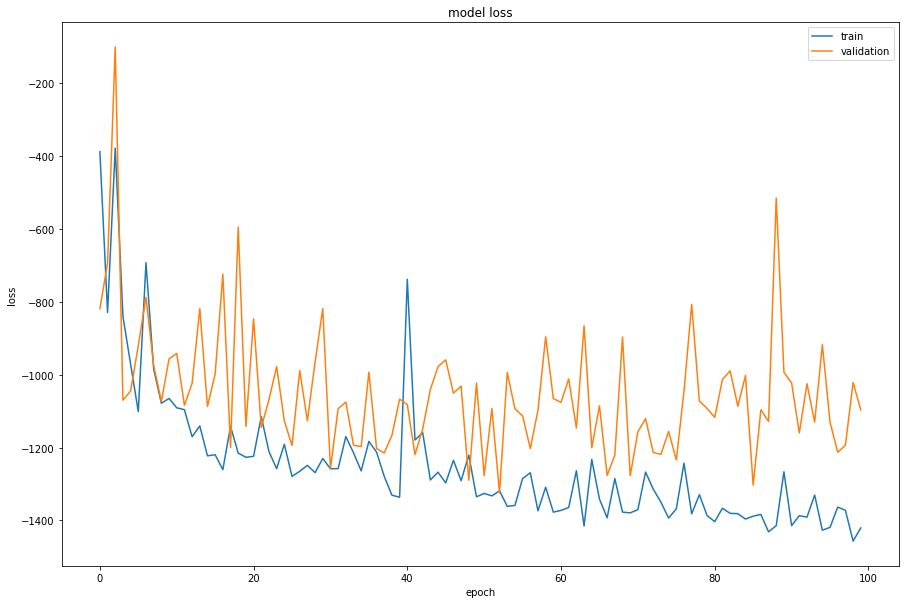

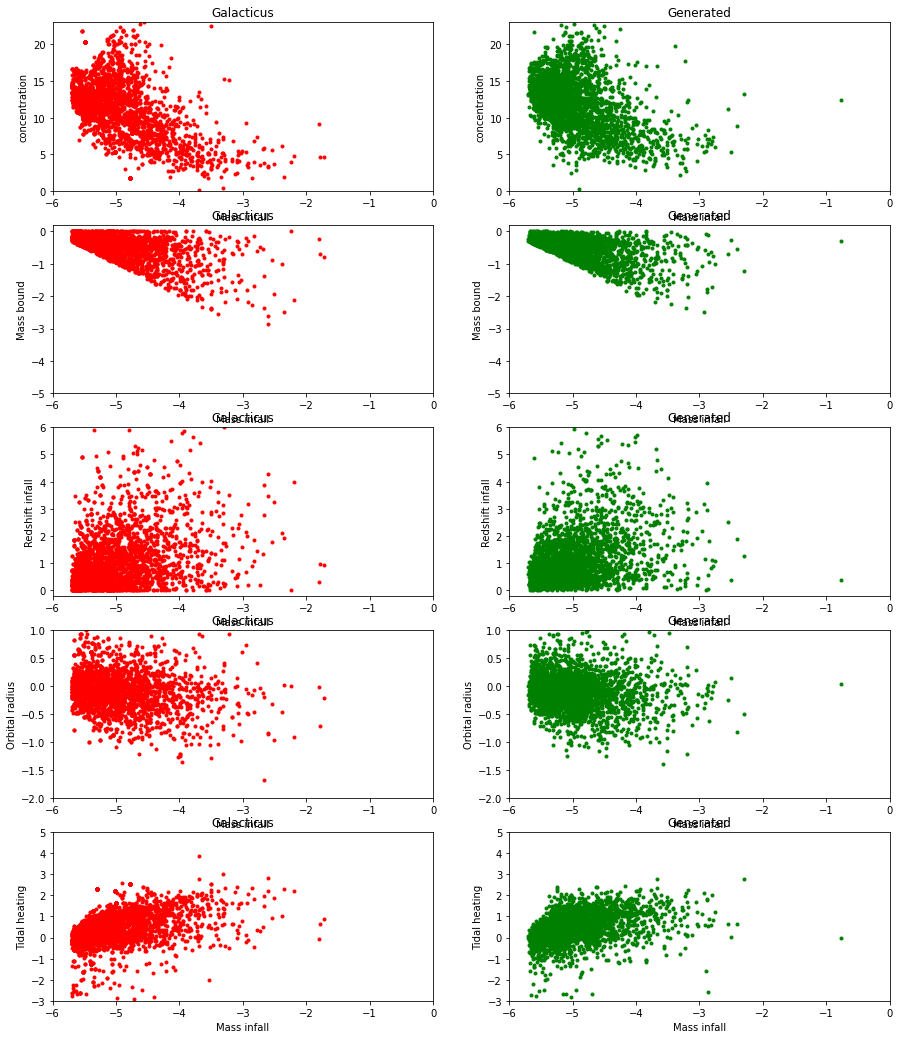

In [11]:
emulator = RealNVP(num_coupling_layers=12)
emulator.load_weights('../data/emulatorModel')

plt.figure(figsize=(15, 10))
plt.plot(history.history["loss"])
plt.plot(history.history["val_loss"])
plt.title("model loss")
plt.legend(["train", "validation"], loc="upper right")
plt.ylabel("loss")
plt.xlabel("epoch")

# From data to latent space.
z, _ = emulator(normalized_data)

# From latent space to data.
samples = emulator.distribution.sample(3000)
x, _ = emulator.predict(samples)
xt = scaler.inverse_transform(x)
clip = (xt[:,0] > np.log10(2.0*massResolution/massTree)) & (xt[:,2] <= 0.0) & (xt[:,2] > -xt[:,0]+np.log10(massResolution/massTree)) & (xt[:,3] >= 0.0)

f, axes = plt.subplots(5, 2)
f.set_size_inches(15, 18)

# Generate a weighted subsample of the original data.
w = weight[subhalos]
i = np.arange(0, w.size, 1, dtype=int)
subsample = np.random.choice(i, size=3000, replace=True, p=w/np.sum(w))

# Compute and compare the ratio of low-to-high-mass subhalos in the original data and in the emulated data.
# For the original data we weight by the subsampling weight. If this was included correctly in the training
# then the emulated data should have effectively learned these weights and produce a ratio similar to that in
# the original data.
s6 = data[:,0] > -6.0
s4 = data[:,0] > -4.0
ratioOriginal = np.sum(data[s6,0]*w[s6])/np.sum(data[s4,0]*w[s4])
print("Ratio of low-to-high-mass subhalos in original data (weighted): "+str(ratioOriginal))

ratioEmulator = np.sum(xt[clip,0] > -6.0)/np.sum(xt[clip,0] > -4.0)
print("Ratio of low-to-high-mass subhalos in emulated data: "+str(ratioEmulator))

axes[0, 0].scatter(data[subsample, 0], data[subsample, 1], color="r", s=9)
axes[0, 0].set(title="Galacticus", xlabel="Mass infall", ylabel="concentration")
axes[0, 0].set_xlim([-6, 0])
axes[0, 0].set_ylim([0, 23])
axes[0, 1].scatter(xt[clip, 0], xt[clip, 1], color="g", s=9)
axes[0, 1].set(title="Generated", xlabel="Mass infall", ylabel="concentration")
axes[0, 1].set_xlim([-6, 0])
axes[0, 1].set_ylim([0, 23])
axes[1, 0].scatter(data[subsample, 0], data[subsample, 2], color="r", s=9)
axes[1, 0].set(title="Galacticus", xlabel="Mass infall", ylabel="Mass bound")
axes[1, 0].set_xlim([-6, 0])
axes[1, 0].set_ylim([-5.0, 0.2])
axes[1, 1].scatter(xt[clip, 0], xt[clip, 2], color="g", s=9)
axes[1, 1].set(title="Generated", xlabel="Mass infall", ylabel="Mass bound")
axes[1, 1].set_xlim([-6, 0])
axes[1, 1].set_ylim([-5.0, 0.2])
axes[2, 0].scatter(data[subsample, 0], data[subsample, 3], color="r", s=9)
axes[2, 0].set(title="Galacticus", xlabel="Mass infall", ylabel="Redshift infall")
axes[2, 0].set_xlim([-6, 0])
axes[2, 0].set_ylim([-0.2, 6.0])
axes[2, 1].scatter(xt[clip, 0], xt[clip, 3], color="g", s=9)
axes[2, 1].set(title="Generated", xlabel="Mass infall", ylabel="Redshift infall")
axes[2, 1].set_xlim([-6, 0])
axes[2, 1].set_ylim([-0.2, 6.0])
axes[3, 0].scatter(data[subsample, 0], data[subsample, 4], color="r", s=9)
axes[3, 0].set(title="Galacticus", xlabel="Mass infall", ylabel="Orbital radius")
axes[3, 0].set_xlim([-6, 0])
axes[3, 0].set_ylim([-2.0, 1.0])
axes[3, 1].scatter(xt[clip, 0], xt[clip, 4], color="g", s=9)
axes[3, 1].set(title="Generated", xlabel="Mass infall", ylabel="Orbital radius")
axes[3, 1].set_xlim([-6, 0])
axes[3, 1].set_ylim([-2.0, 1.0])
axes[4, 0].scatter(data[subsample, 0], data[subsample, 5], color="r", s=9)
axes[4, 0].set(title="Galacticus", xlabel="Mass infall", ylabel="Tidal heating")
axes[4, 0].set_xlim([-6, 0])
axes[4, 0].set_ylim([-3.0, 5.0])
axes[4, 1].scatter(xt[clip, 0], xt[clip, 5], color="g", s=9)
axes[4, 1].set(title="Generated", xlabel="Mass infall", ylabel="Tidal heating")
axes[4, 1].set_xlim([-6, 0])
axes[4, 1].set_ylim([-3.0, 5.0])

Create a function that generates realizations of subhalo populations and writes them to file.

In [12]:
def generateRealization(countRealizations,countSubhalosMean,emulator):
    countSubhalosRealizations = np.random.poisson(countSubhalosMean,countRealizations)
    for i in range(countRealizations):
        print(str(i)+" : "+str(countSubhalosRealizations[i]))

Generate realizations.

In [13]:
generateRealization(100,countSubhalosMean,emulator)

0 : 9598
1 : 9711
2 : 9658
3 : 9685
4 : 9800
5 : 9805
6 : 9743
7 : 9752
8 : 9568
9 : 9713
10 : 9724
11 : 9603
12 : 9553
13 : 9716
14 : 9690
15 : 9861
16 : 9717
17 : 9678
18 : 9805
19 : 9778
20 : 9636
21 : 9630
22 : 9593
23 : 9819
24 : 9652
25 : 9885
26 : 9777
27 : 9763
28 : 9552
29 : 9544
30 : 9864
31 : 9710
32 : 9744
33 : 9826
34 : 9705
35 : 9842
36 : 9718
37 : 9836
38 : 9784
39 : 9677
40 : 9629
41 : 9806
42 : 9681
43 : 9593
44 : 9912
45 : 9675
46 : 9589
47 : 9840
48 : 9766
49 : 9647
50 : 9627
51 : 9679
52 : 9806
53 : 9718
54 : 9672
55 : 9698
56 : 9680
57 : 9748
58 : 9729
59 : 9610
60 : 9596
61 : 9717
62 : 9613
63 : 9640
64 : 9601
65 : 9666
66 : 9637
67 : 9589
68 : 9647
69 : 9762
70 : 9737
71 : 9668
72 : 9880
73 : 9773
74 : 9664
75 : 9664
76 : 9724
77 : 9736
78 : 9765
79 : 9563
80 : 9675
81 : 9698
82 : 9858
83 : 9661
84 : 9712
85 : 9850
86 : 9705
87 : 9764
88 : 9748
89 : 9652
90 : 9562
91 : 9801
92 : 9705
93 : 9604
94 : 9785
95 : 9723
96 : 9683
97 : 9721
98 : 9596
99 : 9710
